# RoadRunner transit model example III - LDTk-based limb darkening

*Author:* Hannu Parviainen<br>
*Last modified:* 16.9.2020

The *LDTk limb darkening model*, ``pytransit.LDTkLDModel``, works as an example of a more complex limb darkening model that is best implemented as a subclass of ``pytransit.LDModel``. The *LDTk limb darkening model* uses *LDTk* to create a set of stellar limb darkening profile samples given the stellar $T_\mathrm{Eff}$, $\log g$, and $z$ with their uncertainties, and uses the profiles directly to calculate the transit. The profiles are created from the PHOENIX-calculated *specific intensity spectra* by Husser (2013), and the model completely avoids approximating the limb darkening profile with an analytical function.

The model is parameter free after the stellar parameters have been given. The model can be *frozen* for model optimisation, and *thawn* for MCMC posterior estimation. When *frozen*, the model returns the average limb darkening profile interpolated from the profile at the given $\mu$ locations. When *thawn*, each model evaluation chooses a random limb darkening profile from the sample and uses interpolation to evaluate the model at the wanted $\mu$ values. 

In [1]:
%pylab inline
rc('figure', figsize=(13,6))

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_lc(time, flux, c=None, ylim=(0.9865, 1.0025), ax=None, alpha=1):
    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = None, ax
    ax.plot(time, flux, c=c, alpha=alpha)
    ax.autoscale(axis='x', tight=True)
    setp(ax, xlabel='Time [d]', ylabel='Flux', xlim=time[[0,-1]], ylim=ylim)
    
    if fig is not None:
        fig.tight_layout()
    return ax

## Import the model

First, we import the ``RoadRunnerModel`` and ``LDTkLDModel`` and some simple transmission functions from *LDTk*.

In [3]:
from pytransit import RoadRunnerModel, LDTkLDModel
from ldtk import sdss_g, sdss_i, sdss_z

In [4]:
time = linspace(-0.05, 0.05, 1500)

## Example 1: single passband

The *LDTkLDModel* is initialised by giving it the stellar parameters and passband transmission functions,

In [5]:
ldm = LDTkLDModel(teff=(5500, 150), logg=(4.5, 0.1), z=(0.0, 0.1), pbs=[sdss_i], frozen=True)

and given to the ``RoadRunnnerModel`` as any other limb darkening model.

In [6]:
tm = RoadRunnerModel(ldm)
tm.set_data(time)

after which the transit model evaluation goes as usual

In [7]:
flux1 = tm.evaluate(k=0.1, ldc=[None], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

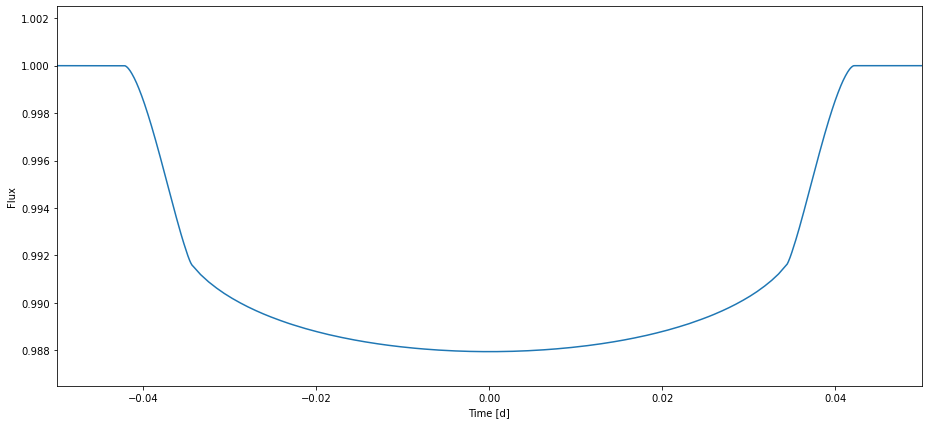

In [8]:
plot_lc(time, flux1);

## Example 2: multiple passbands 

In [9]:
ldm = LDTkLDModel([sdss_g, sdss_z], (5500, 150), (4.5, 0.1), (0.0, 0.1), frozen=True)

In [10]:
lcids = zeros(time.size, int)
lcids[time.size//2:] = 1

In [11]:
tm = RoadRunnerModel(ldm)
tm.set_data(time, lcids=lcids, pbids=[0,1])

In [12]:
flux1 = tm.evaluate(k=0.1, ldc=[None], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

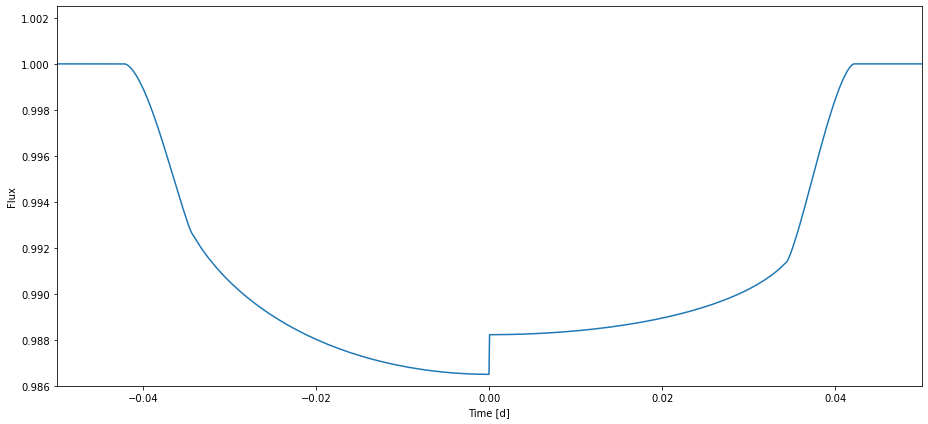

In [13]:
plot_lc(time, flux1, ylim=(0.986, 1.0025));

### Thawing the model

After thawing, the model takes a random sample from the limb darkening profile sample set every time it is evaluated. We don't want this behaviour when fitting a model to observations, since this sort of randomness can easily confuse even the best optimiser, but is exactly what we want then doing MCMC for parameter posterior estimation.

In [14]:
ldm.frozen = False

[0.986, 1.0025]

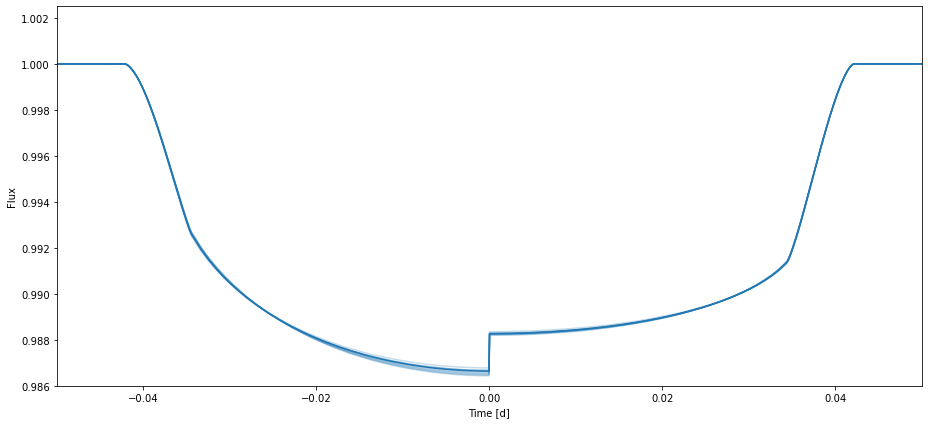

In [15]:
flux1 = tm.evaluate(k=0.1, ldc=[None], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)
ax = plot_lc(time, flux1);

for i in range(10):
    flux1 = tm.evaluate(k=0.1, ldc=[None], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)
    ax = plot_lc(time, flux1, ax=ax, c='C0', alpha=0.25);

setp(ax, ylim=(0.986, 1.0025))

---

<center>©2020 Hannu Parviainen</center>